In [1]:
import torch
from torch import nn
import torchvision
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sym import CNN, Augment
device = "cuda:0" if torch.cuda.is_available() else "cpu"
plt.style.use("dark_paper")

In [2]:
#transform = torchvision.transforms.Pad((280,280))
imagenet_data_train = torchvision.datasets.MNIST(
    "./data/", train=True)  # transform=
imagenet_data_val = torchvision.datasets.MNIST("./data/", train=False)

In [5]:
# Pick some example digits and put them in a 10 by 10 grid (280x280) images
nums = Augment(imagenet_data_train.data)
trainset = torch.utils.data.TensorDataset(
    nums.unsqueeze(1), imagenet_data_train.targets)
# Pick some example digits and put them in a 10 by 10 grid (280x280) images
nums = Augment(imagenet_data_val.data)
valset = torch.utils.data.TensorDataset(
    nums.unsqueeze(1), imagenet_data_val.targets)
del imagenet_data_train, imagenet_data_val

# Data
The validation set is made of digits located somewhere in a 10x10 grid. The training data, on the otherhand, is always located in the top left corner.

Text(0.5, 0.91, 'Validation')

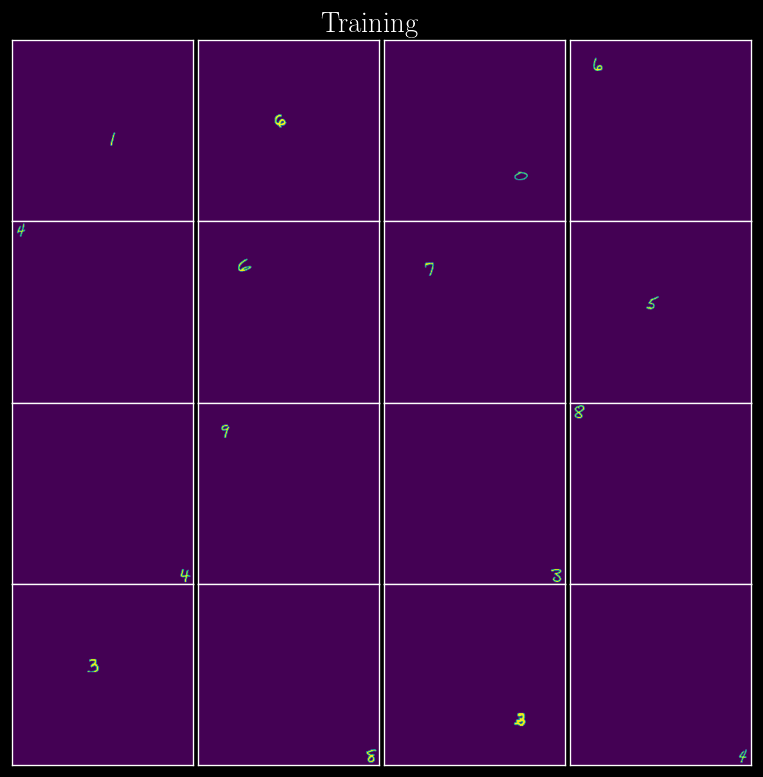

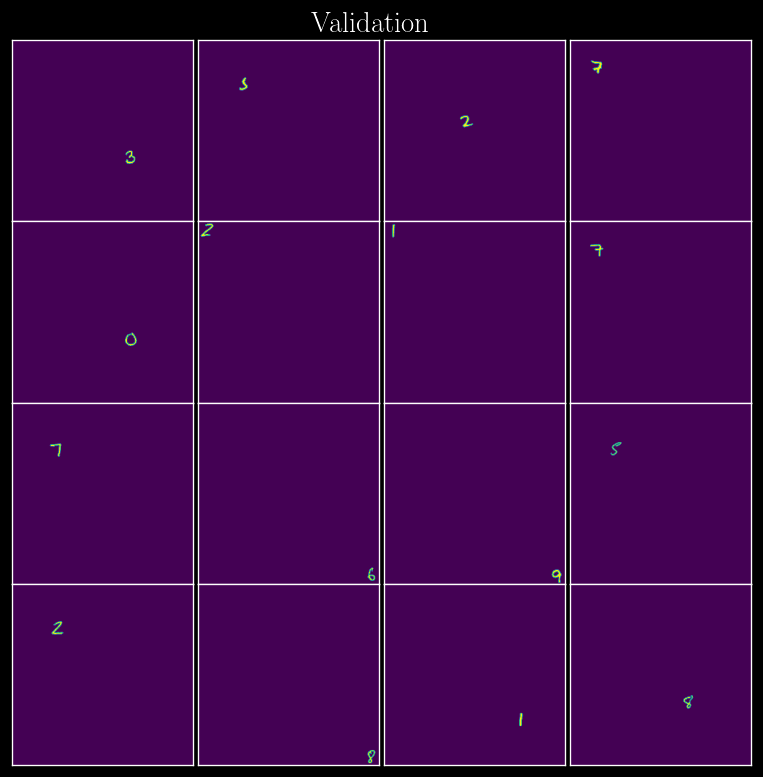

In [7]:
fig, axes = plt.subplots(
    4, 4, sharex=True, sharey=True, figsize=(8, 8), dpi=120)
for i, ax in zip(np.random.randint(0, len(trainset), size=16), axes.flatten()):
    ax.imshow(trainset[i][0][0])
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0)
fig.suptitle("Training", y=.91)

fig, axes = plt.subplots(
    4, 4, sharex=True, sharey=True, figsize=(8, 8), dpi=120)
for i, ax in zip(np.random.randint(0, len(valset), size=16), axes.flatten()):
    ax.imshow(valset[i][0][0])
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0)
fig.suptitle("Validation", y=.91)

In [8]:
fcn = torch.nn.Sequential(torch.nn.Flatten(),
                          torch.nn.Linear(280*280, 1024),
                          torch.nn.ReLU(),
                          torch.nn.Linear(1024, 10))
fcn.to(device)
cnn = torch.nn.Sequential(torch.nn.Conv2d(1, 1024, kernel_size=28, stride=28),
                          torch.nn.BatchNorm2d(1024),
                          torch.nn.ReLU(),
                          torch.nn.MaxPool2d((10, 10)),
                          torch.nn.Flatten(),
                          torch.nn.Linear(1024, 10))  # (10)**2
cnn.to(device)
criterion = torch.nn.CrossEntropyLoss()

# Training some models 

In [9]:
T = 10  # epochs
batch_size = 20
log_step = 1  # validate and print losses every log_steps

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size)

In [10]:
# Define training and validation functions
def train(model, x, y):
    x = x.to(device)
    y = y.to(device)
    model.train()
    yhat = model(x)
    loss = criterion(yhat, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()

def validate(model, x, y):
    x = x.to(device)
    y = y.to(device)
    model.eval()
    with torch.no_grad():
        yhat = model(x)
        loss = criterion(yhat, y)
        return loss.item()

In [16]:
# Define metrics function
def metrics(model):
    with torch.no_grad():
        model.eval()
        model.to(device)
        yhat = []
        for x, y in valloader:
            x = x.to(device)
            yhat.append(model(x).cpu().numpy())
    yhat = np.concatenate(yhat)
    out = classification_report(valset.tensors[1], yhat.argmax(axis=1))
    print(out)


def plot_loss():
    plt.plot(np.arange(0, T), losses_train[0:], label="Train")
    plt.plot(np.arange(0, T, log_step), losses_val, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [27]:
def train_loop(model, T=10, log_step=1):
    losses_train = []
    losses_val = []
    model.train()
    total_steps = len(trainloader)
    for t in range(1, T+1):
        loss = list()  # Combine losses from differetn steps in a single epoch
        # Training Step
        for step, (x, y) in enumerate(trainloader):
            loss_ = train(model, x, y)
            loss.append(loss_)
            print(
                f"Epoch {t:>03d}/{T:^3d} [Step {step+1}/{total_steps}] | Training loss: {loss_:^.4f}", end="\r")
        loss = np.mean(loss)
        losses_train.append(loss)
        # Validation Step
        if t % log_step == 0:
            message = f"Epoch {t:>03d}/{T:^3d} | Training loss: {loss:^.4f} - "
            loss = []
            with torch.no_grad():
                for x, y in valloader:
                    loss_ = validate(model, x, y)
                    loss.append(loss_)
            loss = np.mean(loss)
            losses_val.append(loss)
            message += f"Validation loss: {loss:^.4f}"
            print(message)  # ,end="\r"
    return losses_train, losses_val

#  CNN Training

In [28]:
# Train the CNN for 100 epochs 
optimizer = torch.optim.Adam(cnn.parameters(),lr=1e-2)
losses_train, losses_val = train_loop(cnn,T=T,log_step=log_step)

Epoch 001/10  | Training loss: 0.0745 - Validation loss: 0.1099
Epoch 002/10  | Training loss: 0.0497 - Validation loss: 0.0839
Epoch 003/10  | Training loss: 0.0544 - Validation loss: 0.2053
Epoch 004/10  | Training loss: 0.0499 - Validation loss: 0.1853
Epoch 005/10  | Training loss: 0.0504 - Validation loss: 0.1293
Epoch 006/10  | Training loss: 0.0459 - Validation loss: 0.1576
Epoch 007/10  | Training loss: 0.0481 - Validation loss: 0.1316
Epoch 008/10  | Training loss: 0.0437 - Validation loss: 0.2013
Epoch 009/10  | Training loss: 0.0430 - Validation loss: 0.2281
Epoch 010/10  | Training loss: 0.0430 - Validation loss: 0.2028


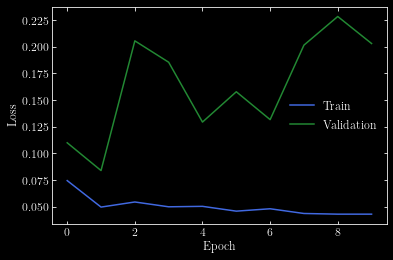

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        53
           1       1.00      1.00      1.00        73
           2       0.97      0.97      0.97        64
           3       0.95      0.98      0.97        62
           4       0.97      0.96      0.96        67
           5       1.00      0.95      0.97        56
           6       0.98      0.96      0.97        52
           7       0.97      1.00      0.98        57
           8       0.98      0.94      0.96        52
           9       0.97      0.97      0.97        64

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600



In [29]:
plot_loss()
metrics(cnn)

# LCN Training

In [30]:
lcn = LCN()
lcn.to(device)

LCN(
  (activation): ReLU(inplace=True)
  (decoder): Linear(in_features=1000, out_features=10, bias=True)
)

In [31]:
optimizer = torch.optim.Adam(lcn.parameters(), lr=1e-2)
losses_train, losses_val = train_loop(lcn, T=T, log_step=log_step)

Epoch 001/10  | Training loss: 4.2408 - Validation loss: 2.3494
Epoch 002/10  | Training loss: 2.3286 - Validation loss: 2.3735
Epoch 003/10  | Training loss: 2.3048 - Validation loss: 2.3584
Epoch 004/10  | Training loss: 2.3016 - Validation loss: 2.3602
Epoch 005/10  | Training loss: 2.3026 - Validation loss: 2.3382
Epoch 006/10  | Training loss: 2.2986 - Validation loss: 2.3360
Epoch 007/10  | Training loss: 2.2883 - Validation loss: 2.3370
Epoch 008/10  | Training loss: 2.3244 - Validation loss: 2.3488
Epoch 009/10  | Training loss: 2.3015 - Validation loss: 2.4054
Epoch 010/10  | Training loss: 2.3004 - Validation loss: 2.3580


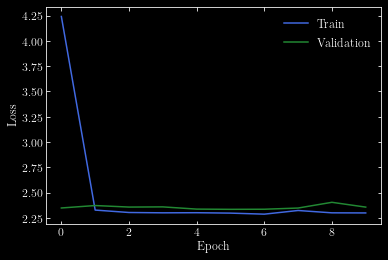

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        53
           1       1.00      0.01      0.03        73
           2       0.00      0.00      0.00        64
           3       0.00      0.00      0.00        62
           4       0.00      0.00      0.00        67
           5       0.00      0.00      0.00        56
           6       0.00      0.00      0.00        52
           7       0.00      0.00      0.00        57
           8       0.09      1.00      0.16        52
           9       0.00      0.00      0.00        64

    accuracy                           0.09       600
   macro avg       0.11      0.10      0.02       600
weighted avg       0.13      0.09      0.02       600



/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
plot_loss()
metrics(lcn)

# FCN Training

In [33]:
optimizer = torch.optim.Adam(fcn.parameters(), lr=1e-2)
losses_train, losses_val = train_loop(fcn, T=T, log_step=log_step)

Epoch 001/10  | Training loss: 2.3013 - Validation loss: 2.3296
Epoch 002/10  | Training loss: 2.3258 - Validation loss: 2.3385
Epoch 003/10  | Training loss: 2.2933 - Validation loss: 2.3314
Epoch 004/10  | Training loss: 2.2957 - Validation loss: 2.3269
Epoch 005/10  | Training loss: 2.2899 - Validation loss: 2.3267
Epoch 006/10  | Training loss: 2.2922 - Validation loss: 2.3384
Epoch 007/10  | Training loss: 2.2932 - Validation loss: 2.3373
Epoch 008/10  | Training loss: 2.2911 - Validation loss: 2.3320
Epoch 009/10  | Training loss: 2.2889 - Validation loss: 2.3302
Epoch 010/10  | Training loss: 2.2993 - Validation loss: 2.3322


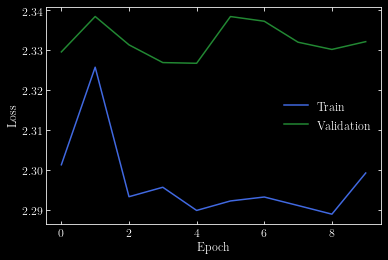

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        53
           1       0.80      0.05      0.10        73
           2       0.00      0.00      0.00        64
           3       0.50      0.02      0.03        62
           4       0.50      0.01      0.03        67
           5       0.00      0.00      0.00        56
           6       0.00      0.00      0.00        52
           7       0.00      0.00      0.00        57
           8       0.09      1.00      0.16        52
           9       0.00      0.00      0.00        64

    accuracy                           0.10       600
   macro avg       0.19      0.11      0.03       600
weighted avg       0.21      0.10      0.03       600



/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
plot_loss()
metrics(fcn)